# Preprocessing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix  # LightFM fit method requires coo matrix format as input.

from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k
from sklearn.metrics import roc_auc_score
from lightfm.data import Dataset

/Users/konstantinorlovskiy/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


### Data Import and Cleaning - Events

In [2]:
# Importing Events data and sorting by timestamp column which corresponds the historical order of events.

df_events = pd.read_csv("events.csv")
df_events = df_events.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

In [3]:
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,addtocart,297662,NaN
1,1430622011289,829044,view,60987,NaN
2,1430622013048,652699,view,252860,NaN
3,1430622024154,1125936,view,33661,NaN
4,1430622026228,693516,view,297662,NaN


In [4]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            object
itemid           int64
transactionid    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


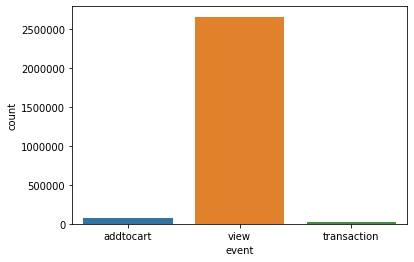

In [5]:
# View on the ratio between different types of events.
sns.countplot(x='event', data=df_events)

In [6]:
# Events types “view”, “addtocart”, “transaction” are the implicit customer feedback.
# They can be considered as rating and will be transformed from categorical to numerical format.

# The weights are subject to tuning together with hyperparameters to achieve better performance.

weight_view = 1
weight_addtocart = 2
weight_transaction = 3

df_events.event.replace(to_replace=dict(
    view=weight_view, addtocart=weight_addtocart, transaction=weight_transaction), inplace=True)

In [7]:
# Now the events replaced with corresponding weights.
df_events.event.unique()

array([2, 1, 3])

In [8]:
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,2,297662,NaN
1,1430622011289,829044,1,60987,NaN
2,1430622013048,652699,1,252860,NaN
3,1430622024154,1125936,1,33661,NaN
4,1430622026228,693516,1,297662,NaN


In [9]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            int64
itemid           int64
transactionid    float64
dtypes: float64(1), int64(4)
memory usage: 105.1 MB


In [10]:
# The user may have interacted with item multiple times which is now stored in dataframe.
# For the purpose of recommendation we're interested in the highest level of user interest to the item.
# Therefore, the data can be further cleaned.

df_events = df_events.sort_values('event').drop_duplicates(
    subset=['visitorid', 'itemid'], 
    keep='last').sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

In [11]:
print(df_events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145179 entries, 0 to 2145178
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            int64
itemid           int64
transactionid    float64
dtypes: float64(1), int64(4)
memory usage: 81.8 MB
None


In [12]:
# Those users that had low activiti must be removed from the data.
# Considering number of users and items it won't be possible to evaluate predictions having no user features.
# Therefore, it makes sense to delete these users, which will remove noise and save computational cost.
# At the same time, items with low interactions can be kept as there's item features data available.

# !!!
# Before production the model should be additionally trained on the interactions of removed users.

In [13]:
# Count activities by user.
users_activity = df_events.groupby('visitorid').visitorid.count().to_frame(name='activity_count')
users_activity.head()

,activity_count
visitorid,
0,3
1,1
2,4
3,1
4,1


In [14]:
users_activity.loc[users_activity['activity_count'] > 10].head()

,activity_count
visitorid,
155,13
172,22
351,14
549,17
627,12


In [15]:
df_events.loc[df_events['visitorid'] == 627]

,timestamp,visitorid,event,itemid,transactionid
1748711,1440098972726,627,1,361587,NaN
1749094,1440100359389,627,1,210786,NaN
1749109,1440100416615,627,1,149319,NaN
1749120,1440100457311,627,1,230187,NaN
1749125,1440100487366,627,1,47236,NaN
1749137,1440100516099,627,1,316826,NaN
1749174,1440100645793,627,1,189109,NaN
1749196,1440100726843,627,1,283067,NaN
1749537,1440101891332,627,1,304332,NaN
1750030,1440103716892,627,3,414182,1332.0


In [16]:
# See the ratio of users having only low level of interaction.

interaction_threshold = 3

users_activity_low = users_activity.loc[users_activity['activity_count'] <= interaction_threshold]
ratio = len(users_activity_low) / len(users_activity)
print('Users with <=', interaction_threshold, 'interactions represent', round(ratio*100,2),
      '% of total interactions and are to be removed.')

Users with <= 3 interactions represent 95.5 % of total interactions and are to be removed.


In [17]:
# Create list of users that need to be removed from events data.
users_to_remove = users_activity_low.index.tolist()
len(users_to_remove)

1344286

In [18]:
# Remove users with only 1 interaction from df_events dataframe.
df_events = df_events[~df_events.visitorid.isin(users_to_remove)].reset_index(drop=True)

In [19]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521872 entries, 0 to 521871
Data columns (total 5 columns):
timestamp        521872 non-null int64
visitorid        521872 non-null int64
event            521872 non-null int64
itemid           521872 non-null int64
transactionid    12800 non-null float64
dtypes: float64(1), int64(4)
memory usage: 19.9 MB


### Train / Test split

In [20]:
# Use timestamps for split which mimics the real-life case as the events are sorted in historical order.
# Split ratio is 80% for train set, and 20% for test set.

split_point = int(np.ceil(len(df_events)*0.8))  # Index of split point.
split_point_time = int(df_events.loc[split_point]['timestamp'])  # Timestamp of split point.

df_events_train = df_events.loc[0:split_point]
df_events_test = df_events.loc[split_point+1:]


# Exclude from test set those users and items that are no included in train set. 
# df_events_test = df_events_test[(df_events_test['visitorid'].isin(df_events_train['visitorid'])) & 
#                                (df_events_test['itemid'].isin(df_events_train['itemid']))]


df_events_train.info()
print()
df_events_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417499 entries, 0 to 417498
Data columns (total 5 columns):
timestamp        417499 non-null int64
visitorid        417499 non-null int64
event            417499 non-null int64
itemid           417499 non-null int64
transactionid    10000 non-null float64
dtypes: float64(1), int64(4)
memory usage: 15.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104373 entries, 417499 to 521871
Data columns (total 5 columns):
timestamp        104373 non-null int64
visitorid        104373 non-null int64
event            104373 non-null int64
itemid           104373 non-null int64
transactionid    2800 non-null float64
dtypes: float64(1), int64(4)
memory usage: 4.0 MB


### Building LightFM datasets

In [21]:
# For model evaluation purposes (auc_score) dimensionality of train/test interaction matrices should be the same.
# In order to achieve this, need to create mapping for all users and all items.
# Then separately for train and test - the interactions will be filled in.

In [22]:
# Create mapping.

# The fit method of class Dataset takes the list of all the visitors and items.
# The implementation allows to ignore duplicates.

# Train set mapping.
dataset_train = Dataset()
dataset_train.fit(
    df_events['visitorid'].to_numpy(),
    df_events['itemid'].to_numpy()
)

# Train set mapping.
dataset_test = Dataset()
dataset_test.fit(
    df_events['visitorid'].to_numpy(),
    df_events['itemid'].to_numpy()
)

In [23]:
# Transform interactions in required format.

# Dataset class has the method build_interactions that allows to fill in the matrix created at previous step.
# As the input for this method need to pass the list of tuples (visitorid, itemid, weight).

start_time = time.time()

# Train set interactions transformed.
df_events_train_interactions = []
for index, row in df_events_train.iterrows():
    df_events_train_interactions.append((int(row['visitorid']), int(row['itemid']), int(row['event'])))
    
# Test set interactions transformed.
df_events_test_interactions = []
for index, row in df_events_test.iterrows():
    df_events_test_interactions.append((int(row['visitorid']), int(row['itemid']), int(row['event'])))
    
print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.47  minutes


In [24]:
# Check original VS transformed length, should be equal.

print('Check original VS transformed length TRAIN: ', 
     len(df_events_train),
     ' / ',
     len(df_events_train_interactions))

print('Check original VS transformed length TEST: ', 
     len(df_events_test),
     ' / ',
     len(df_events_test_interactions))

Check original VS transformed length TRAIN:  417499  /  417499
Check original VS transformed length TEST:  104373  /  104373


In [25]:
# Build interactions matrix for train and test sets

start_time = time.time()

(interactions_train, weights_train) = dataset_train.build_interactions(df_events_train_interactions)
(interactions_test, weights_test) = dataset_test.build_interactions(df_events_test_interactions)

print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.02  minutes


In [26]:
weights_train

<63294x103218 sparse matrix of type '<class 'numpy.float32'>'
	with 417499 stored elements in COOrdinate format>

In [27]:
weights_test

<63294x103218 sparse matrix of type '<class 'numpy.float32'>'
	with 104373 stored elements in COOrdinate format>

# LightFM model training

In [28]:
# Building model without item features first. This will mean collaboration based predictions.

start_time = time.time()

model = LightFM(no_components=50, loss='warp', random_state=2020)
model.fit(weights_train, epochs=100, num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

Model trained in:  1.59  minutes


# Model evaluation (auc_score, precision_at_k)

In [29]:
# Since the recommendation engine is a ranking problem, AUC ROC and Precision at K will be used.
# Both of them are measuring the ranking quality.


In [30]:
start_time = time.time()

train_auc = auc_score(model, 
                      weights_train, 
                      num_threads=4).mean()

print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train AUC score:  0.99995303
Calculated in:  5.72  minutes


In [31]:
start_time = time.time()

# Train interactions fill be also passed to avoid model re-recommending items to users.
test_auc = auc_score(model,
                     weights_test, 
                     train_interactions = weights_train, 
                     num_threads=4).mean()

print('Test AUC score: ', test_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test AUC score:  0.66738844
Calculated in:  2.29  minutes


In [32]:
start_time = time.time()

train_precision = precision_at_k(model, 
                                 weights_train,
                                 num_threads=4, 
                                 k=10).mean()

print('Train precision at k: ', train_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train precision at k:  0.4306436
Calculated in:  5.95  minutes


In [33]:
start_time = time.time()

test_precision = precision_at_k(model, 
                                weights_test, 
                                train_interactions = weights_train, 
                                num_threads=4, 
                                k=10).mean()

print('Test precision at k: ', test_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test precision at k:  0.0040189787
Calculated in:  2.17  minutes
